<a href="https://colab.research.google.com/github/lmassaron/fine-tuning-workshop/blob/main/05_fine_tuning_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune Gemma 3 1B-IT for Sentiment Analysis

This tutorial covers the **fine-tuning process** of the recently launched **Gemma 3 1B** model for **sentiment analysis** on financial and economic information. Sentiment analysis in this domain is crucial for businesses for several reasons, including:

- **Market Insights**: Gaining valuable insights into market trends, investor confidence, and consumer behavior.  
- **Risk Management**: Identifying potential reputational risks.  
- **Investment Decisions**: Assessing the sentiment of stakeholders, investors, and the general public to evaluate investment opportunities.  

Before diving into the technical aspects of fine-tuning a large language model like **Gemma**, we must first select an appropriate **dataset** to showcase its capabilities.

## Introducing the Gemma 3 1B-IT

**Gemma 3** is Google's latest addition to its family of lightweight, state-of-the-art open AI models, designed to deliver high performance while being resource-efficient. The **1B Instruct** version of **Gemma 3** is tailored for **instruction-based tasks**, offering developers an accessible and powerful tool for creating intelligent applications.  

Announcement: [Gemma 3 Blog Post](https://blog.google/technology/developers/gemma-3/)

Gemma 3 features a **transformer architecture** optimized with advanced techniques, enabling sophisticated reasoning and text generation capabilities.

Key Features:
- **128K-token context window**: Allows processing and understanding of vast amounts of information.  
- **Multilingual support**: Over **140 languages**, ideal for global applications.  
- **Multimodal capabilities**: Supports text, images, and videos, enabling interactive AI solutions.  
- **Edge device optimization**: Efficiently runs on consumer hardware with a single GPU, making it accessible for developers with limited resources.

Resources:
- [Gemma 3 Model Overview](https://ai.google.dev/gemma/docs/core)  
- [Gemma 3 Technical Report](https://storage.googleapis.com/deepmind-media/gemma/Gemma3Report.pdf)  
- [Gemma 3 Model Card](https://ai.google.dev/gemma/docs/core/model_card_3)

## Dataset Selection

Annotated datasets for finance and economic texts are relatively rare, with many being proprietary. To address this challenge, researchers from the **Aalto University School of Business** introduced the **FinancialPhraseBank Dataset** in 2014, which contains approximately **5,000 sentences**.  

This dataset provides **human-annotated benchmarks**, allowing for consistent evaluation of different modeling techniques. The annotations were performed by **16 individuals** with a background in **financial markets**, who categorized the sentences as having a:

- **Positive** impact on stock prices  
- **Negative** impact on stock prices  
- **Neutral** impact on stock prices  

The impact was assessed from an **investor's perspective**.

## More on the FinancialPhraseBank Dataset

The **FinancialPhraseBank** dataset is a comprehensive collection of **financial news headlines** analyzed from the viewpoint of **retail investors**. It includes two key columns:

- **Sentiment**: Classified as **negative**, **neutral**, or **positive**.  
- **News Headline**: The actual **financial news snippet**.

This dataset has been widely used in research, including the study by **Malo, P.**, **Sinha, A.**, **Korhonen, P.**, **Wallenius, J.**, and **Takala, P.**, titled "*Good Debt or Bad Debt: Detecting Semantic Orientations in Economic Texts*" (published in the **Journal of the Association for Information Science and Technology**, 2014).

## Required Libraries

To implement this tutorial, we need to install several essential libraries:

In [1]:
# Check the GPU information
!nvidia-smi

Thu Sep 25 16:55:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install necessary libraries for model training and evaluation
%%capture
!pip install -U transformers trl peft accelerate bitsandbytes

### Explanation of Key Libraries  

- **`transformers`**: Provides a framework to handle **pre-trained NLP models** for tasks like **text classification** and **question answering**.  

- **`accelerate`**: A distributed training library by Hugging Face designed for **parallelizing training** across multiple **GPUs or CPUs**.  

- **`peft`**: A library for **parameter-efficient fine-tuning (PEFT)** of pre-trained language models, including support for **LoRA (Low-Rank Adaptation)**.  

- **`trl`**: A Hugging Face library for training **transformer models** with **supervised fine-tuning** or **reinforcement learning techniques**.  

-   **`bitsandbytes`**: A lightweight library that provides custom CUDA functions for **8-bit and 4-bit quantization** of PyTorch models. This significantly reduces the memory footprint of large language models, making it possible to run them on less powerful hardware. `bitsandbytes` offers features like 8-bit optimizers and 4-bit quantization with QLoRA, which enables training large models with reduced memory requirements without compromising performance.

## Setting Environment Variables

The following code sets environment variables to configure the GPU usage and suppress unnecessary warnings:

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Use the first GPU
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Disable tokenization parallelism

## Suppressing Warnings

During training, several warnings may appear that do not impact the fine-tuning process but can be distracting. To suppress them:

In [4]:
import warnings
warnings.filterwarnings("ignore")

Global variable for demonstrations

In [5]:
DEMO = False

## Importing Necessary Libraries

The following Python libraries are required for running the fine-tuning process:

In [6]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)

from transformers.models.gemma3 import Gemma3ForCausalLM

from datasets import Dataset
from peft import LoraConfig, PeftConfig, PeftModel
from trl import SFTTrainer, SFTConfig
import bitsandbytes as bnb

from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

To check the installed version of the transformers library:

In [7]:
print(f"transformers=={transformers.__version__}")

transformers==4.56.2


This function determines the best computing device for running the tutorial:

In [8]:
def define_device():
    """Determine and return the optimal PyTorch device based on availability."""

    print(f"PyTorch version: {torch.__version__}", end=" -- ")

    # Check if MPS (Metal Performance Shaders) is available for macOS
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        print("using MPS device on macOS")
        return torch.device("mps")

    # Check for CUDA availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"using {device}")
    return device

This code initializes the Gemma 3 1B model for causal language modeling, ensuring optimal settings based on the available hardware.  

* If the GPU supports **bfloat16** (available on GPUs with Compute Capability **8.0+**), it is used for computations.  
  Otherwise, **float16** is used as the default.  

* **Device Selection:**  
  * The function `define_device()` selects the best available device (**CPU, CUDA, or MPS**).  

* **Model Initialization:**  
  * The model is loaded with memory-efficient configurations, including `low_cpu_mem_usage=True`, and assigned to the selected device.  

* **Tokenizer Setup:**  
  * A **tokenizer** is initialized with a **maximum sequence length of 1024**.  
  * The **end-of-sequence (EOS) token** is stored for later use.  

In [9]:
# Determine optimal computation dtype based on GPU capability
compute_dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
print(f"Using compute dtype {compute_dtype}")

# Select the best available device (CPU, CUDA, or MPS)
device = define_device()
print(f"Operating on {device}")

# Path to the pre-trained model
GEMMA_PATH = "google/gemma-3-1b-it"

# Load the model with optimized settings
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

model = Gemma3ForCausalLM.from_pretrained(
    GEMMA_PATH,
    torch_dtype=compute_dtype,
    attn_implementation="eager",
    low_cpu_mem_usage=True,
    quantization_config=quantization_config,
    device_map="auto"
)

# Define maximum sequence length for the tokenizer
max_seq_length = 1024

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    GEMMA_PATH,
    max_seq_length=max_seq_length,
    device_map=device
)

# Store the EOS token for later use
EOS_TOKEN = tokenizer.eos_token

`torch_dtype` is deprecated! Use `dtype` instead!


Using compute dtype torch.float16
PyTorch version: 2.8.0+cu126 -- using cuda
Operating on cuda


config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [10]:
print(f"Model: {model.name_or_path}")
print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

if hasattr(model, "is_quantized") and model.is_quantized:
    # The quantization_config attribute holds the BitsAndBytesConfig object
    print("Quantization: Enabled")
    print(f"  - 4bit: {model.is_loaded_in_4bit}")
    print(f"  - Quant Type: {model.hf_quantizer.quantization_config.bnb_4bit_quant_type}")
    print(f"  - Compute DType: {model.hf_quantizer.quantization_config.bnb_4bit_compute_dtype}")
else:
    print("Quantization: Disabled")

Model: google/gemma-3-1b-it
Device: cuda:0
DType: torch.float16
Quantization: Enabled
  - 4bit: True
  - Quant Type: nf4
  - Compute DType: torch.float16


Before proceeding, let's ensures that the entire model is correctly moved to the GPU.


In [11]:
is_on_gpu = all(param.device.type == 'cuda' for param in model.parameters())
print("Model is on GPU:", is_on_gpu)

Model is on GPU: True


The following code prepares the dataset for fine-tuning a sentiment analysis model using Gemma. It follows these steps:  

1. **Load Dataset**  
   * Reads the dataset from `all-data.csv`, which contains two columns:  
     - **sentiment**: The sentiment label (positive, neutral, negative).  
     - **text**: The financial news headlines.  

2. **Stratified Train-Test Split**  
   * The dataset is split into **training** and **test** sets, each containing **300 samples per sentiment class**.  
   * **Stratification** ensures that each set has an equal distribution of positive, neutral, and negative examples.  

3. **Shuffle Training Data**  
   * The training data is shuffled using `random_state=10` to ensure **replicability**.  

4. **Prepare Evaluation Data**  
   * The remaining (unselected) data is assigned to an **evaluation set (`X_eval`)**.  
   * To ensure **balanced evaluation**, each sentiment class is resampled to have **50 instances** (negative samples are duplicated if needed).  

5. **Convert Text into Prompts**  
   * The **training** and **evaluation** data are transformed into **prompts** that instruct the model to classify sentiment.  
   * **Training prompts** include sentiment labels (used for fine-tuning).  
   * **Test prompts** omit sentiment labels (used for inference).  

6. **Wrap Data Using Hugging Face's Dataset Class**  
   * Converts `train_data`, `eval_data`, and `test_data` into **Hugging Face Dataset objects** for compatibility with the training pipeline.

In [12]:
# Load dataset
filename = "https://github.com/lmassaron/Gemma-3-1B-financial-sentiment-analysis/raw/refs/heads/main/all-data.csv"
df = pd.read_csv(filename,
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

# Initialize lists for train and test sets
X_train, X_test = [], []

# Stratified train-test split (300 per sentiment)
for sentiment in ["positive", "neutral", "negative"]:
    train, test = train_test_split(df[df.sentiment == sentiment],
                                   train_size=300,
                                   test_size=300,
                                   random_state=42,
                                   stratify=df[df.sentiment == sentiment]["sentiment"])
    X_train.append(train)
    X_test.append(test)

# Combine and shuffle training data
X_train = pd.concat(X_train).sample(frac=1, random_state=10).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)

# Identify indices not included in train or test sets
selected_indices = set(X_train.index) | set(X_test.index)
X_eval = df.loc[~df.index.isin(selected_indices)].copy()

# Resample evaluation data to maintain class balance (50 per class, with replacement for minority class)
X_eval = X_eval.groupby('sentiment', group_keys=False).apply(
    lambda x: x.sample(n=50, random_state=10, replace=True)
).reset_index(drop=True)

In [13]:
# Function to generate training and evaluation prompts
def generate_train_prompt(data_point):
    return f"""
    Analyze the sentiment of the news headline enclosed in square brackets.
    Determine if it is positive, neutral, or negative, and return the corresponding sentiment label:
    "positive", "neutral", or "negative".

    [{data_point["text"]}] = {data_point["sentiment"]}
    """.strip() + EOS_TOKEN

# Function to generate test prompts (without expected answer)
def generate_test_prompt(data_point):
    return f"""
    Analyze the sentiment of the news headline enclosed in square brackets.
    Determine if it is positive, neutral, or negative, and return the corresponding sentiment label:
    "positive", "neutral", or "negative".

    [{data_point["text"]}] =
    """.strip()

In [14]:
# Apply prompt generation to datasets
X_train = pd.DataFrame(X_train.apply(generate_train_prompt, axis=1), columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_train_prompt, axis=1), columns=["text"])

# Store ground truth labels for test data
y_true = X_test["sentiment"]
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

# Convert to Hugging Face Dataset format
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

The following function evaluates the performance of our **fine-tuned sentiment analysis model** by performing the following tasks:

**1. Map Sentiment Labels to Numeric Values**
- **Positive** → `2`
- **Neutral** → `1`
- **Negative** → `0`
- Additionally, handles cases where the label is `'none'` by mapping it to **`1 (neutral)`**.

**2. Calculate Overall Accuracy**
- Computes the accuracy of the model predictions (`y_pred`) compared to the actual sentiment labels (`y_true`).

**3. Compute Accuracy for Each Sentiment Label**
- Extracts **accuracy scores** separately for:
  - **Positive**
  - **Neutral**
  - **Negative**

**4. Generate a Classification Report**
- Prints **precision, recall, and F1-score** for each sentiment category.

**5. Compute and Display the Confusion Matrix**
- Displays a **confusion matrix** to show how often the model misclassifies sentiments (e.g., predicting **neutral** instead of **positive**).


In [15]:
def evaluate(y_true, y_pred):
    """Evaluate the fine-tuned sentiment model's performance."""

    # Define sentiment label mapping
    label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

    # Convert labels to numeric values
    y_true = np.array([label_mapping.get(label, 1) for label in y_true])
    y_pred = np.array([label_mapping.get(label, 1) for label in y_pred])

    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Overall Accuracy: {accuracy:.3f}')

    # Compute accuracy for each sentiment label
    unique_labels = np.unique(y_true)  # Get unique labels in y_true

    for label in unique_labels:
        label_mask = y_true == label  # Mask to filter specific class
        label_accuracy = accuracy_score(y_true[label_mask], y_pred[label_mask])
        print(f'Accuracy for label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {label_accuracy:.3f}')

    # Generate classification report
    class_report = classification_report(y_true, y_pred, target_names=label_mapping.keys())
    print('\nClassification Report:\n', class_report)

    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:\n', conf_matrix)

The following function predicts the sentiment of news headlines. It takes three arguments:

- **X_test**: A Pandas DataFrame containing the news headlines to be analyzed.
- **model**: The pre-trained **Gemma-3 4B** language model.
- **tokenizer**: The corresponding tokenizer for the **Gemma-3 4B** model.

### **Function Workflow:**
1. **Iterate through each news headline** in `X_test`:
   - Construct a prompt asking the model to analyze the sentiment.
   - Tokenize the input and move it to the appropriate device (GPU/CPU).
   - Generate text using the model and extract the predicted sentiment label.
   - Append the sentiment label to `y_pred`.

2. **Use the `generate()` function** from the Hugging Face Transformers library:
   - `max_new_tokens=5`: Limits the number of generated tokens.
   - `temperature=0.0`: Ensures deterministic output.

3. **Extract the sentiment label** from the generated text:
   - If the text contains "positive", assign the label **positive**.
   - If the text contains "negative", assign the label **negative**.
   - If the text contains "neutral", assign the label **neutral**.
   - If none of these are found, assign **none** as a fallback.

In [16]:
def predict(X_test, model, tokenizer, device=device, max_new_tokens=5, temperature=0.0):
    """Predict the sentiment of news headlines"""

    y_pred = []  # List to store predicted sentiment labels

    # Iterate through each headline in X_test
    for i in tqdm(range(len(X_test)), desc="Predicting Sentiments"):
        prompt = X_test.iloc[i]["text"]  # Extract headline text

        # Tokenize and move input to the appropriate device
        input_ids = tokenizer(prompt, return_tensors="pt").to(device)

        # Generate output from the model
        if temperature > 0:
          params = {"do_sample": True, "temperature": temperature}
        else:
          params = {"do_sample": False}

        outputs = model.generate(**input_ids,
                                 max_new_tokens=max_new_tokens,
                                 **params)

        # Decode the generated output into text
        result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip().lower()
        result = result.split("=")[-1]

        # Extract sentiment from the generated text
        if "positive" in result:
            y_pred.append("positive")
        elif "negative" in result:
            y_pred.append("negative")
        elif "neutral" in result:
            y_pred.append("neutral")
        else:
            y_pred.append("none")  # Fallback to error if no clear sentiment is detected

    return y_pred

At this stage, we are ready to test the **Gemma-3 1B** model on our dataset **without any fine-tuning**. This initial evaluation provides insights into the model's **inherent performance** and helps establish a **baseline** for comparison with future fine-tuned models.

We use the `predict` function to generate sentiment predictions for the test set:

In [17]:
y_pred = predict(X_test, model, tokenizer)

Predicting Sentiments: 100%|██████████| 900/900 [08:39<00:00,  1.73it/s]


In the next step, we evaluate the model's predictions against the true sentiment labels:

In [18]:
evaluate(y_true, y_pred)

Overall Accuracy: 0.444
Accuracy for label 0 (negative): 0.223
Accuracy for label 1 (neutral): 0.200
Accuracy for label 2 (positive): 0.910

Classification Report:
               precision    recall  f1-score   support

    positive       0.85      0.22      0.35       300
     neutral       0.45      0.20      0.28       300
    negative       0.40      0.91      0.55       300

    accuracy                           0.44       900
   macro avg       0.56      0.44      0.39       900
weighted avg       0.56      0.44      0.39       900


Confusion Matrix:
 [[ 67  50 183]
 [  9  60 231]
 [  3  24 273]]


We employ the `SFTTrainer`, a specialized trainer from the TRL library, to conduct supervised fine-tuning. This trainer is optimized for fine-tuning pre-trained models, especially when working with smaller datasets, and it simplifies the overall workflow.

The core of our efficiency comes from the **Parameter-Efficient Fine-Tuning (PEFT)** method. Instead of retraining all the parameters of the LLM, PEFT techniques like LoRA focus on a small subset of parameters. This approach significantly reduces computational and storage costs while mitigating the risk of "catastrophic forgetting," where a model loses its original capabilities after fine-tuning.

### `LoraConfig`

The `peft_config` object, an instance of `LoraConfig`, specifies the parameters for the LoRA fine-tuning process.

-   **`lora_alpha`**: This acts as a scaling factor for the LoRA updates. It's a hyperparameter that can be tuned, and a common practice is to set it to twice the value of `r`. In this configuration, it is set to `32`.
-   **`lora_dropout`**: This specifies the dropout probability for the LoRA layers, which helps in preventing overfitting. Here, it is set to `0.05`.
-   **`r`**: This parameter, also known as the rank, determines the dimension of the low-rank matrices used in LoRA. A higher rank results in more trainable parameters. In this case, the rank is `64`.
-   **`bias`**: This defines which biases to train. Setting it to "`none`" means no biases will be trained.
-   **`task_type`**: This specifies the type of task the model is being fine-tuned for. For language generation models, this is set to "`CAUSAL_LM`" (Causal Language Modeling).
-   **`target_modules`**: This indicates which modules within the model's architecture to apply LoRA to. Here, "`all-linear`" applies LoRA to all linear layers.

### `SFTConfig`

The `training_arguments` object, an instance of `SFTConfig`, holds all the arguments for the training process itself. `SFTConfig` is a subclass of the `TrainingArguments` class from the Transformers library, with additional parameters specific to supervised fine-tuning.

-   **`output_dir`**: The directory where training logs and checkpoints are saved.
-   **`num_train_epochs`**: The total number of training epochs to perform.
-   **`gradient_checkpointing`**: A technique to reduce GPU memory usage at the cost of a slight slowdown in training.
-   **`per_device_train_batch_size`**: The batch size for training on each GPU.
-   **`gradient_accumulation_steps`**: The number of batches to process before performing a backward/update pass. This effectively increases the batch size.
-   **`optim`**: The optimizer to use for training. "`adamw_torch_fused`" is a memory-efficient version of the AdamW optimizer.
-   **`save_steps`**: A checkpoint is saved every `50` steps.
-   **`load_best_model_at_end`**: If set to `True`, the best model checkpoint will be loaded at the end of training.
-   **`logging_steps`**: Training metrics are logged every `25` steps.
-   **`learning_rate`**: The initial learning rate for the optimizer.
-   **`weight_decay`**: The amount of weight decay to apply for regularization.
-   **`fp16` / `bf16`**: These booleans enable 16-bit precision training (either float16 or bfloat16) to speed up training and reduce memory usage, depending on the available hardware.
-   **`max_grad_norm`**: The maximum value for gradient clipping, used to prevent exploding gradients.
-   **`max_steps`**: The total number of training steps. If set to `-1`, it is determined by the number of epochs.
-   **`warmup_ratio`**: The proportion of training steps used for a learning rate warm-up.
-   **`group_by_length`**: If true, sequences of similar lengths are grouped together in batches to minimize padding and increase training efficiency.
-   **`eval_strategy`**: Specifies the evaluation strategy. "`steps`" means evaluation is performed at regular step intervals.
-   **`eval_steps`**: Evaluation is performed every `50` training steps.
-   **`eval_accumulation_steps`**: The number of prediction steps to accumulate before moving the results to the CPU.
-   **`lr_scheduler_type`**: The type of learning rate scheduler.
-   **`report_to`**: The integrations to report results to, in this case, "`tensorboard`".
-   **`max_length`**: The maximum sequence length for the model.
-   **`packing`**: If `True`, multiple short examples are packed into a single input sequence to improve training efficiency.
-   **`dataset_kwargs`**: A dictionary of keyword arguments to pass to the dataset processing function.

### `SFTTrainer`

The `SFTTrainer` is initialized with the model, datasets, configurations, and tokenizer.

-   **`model`**: The instantiated model that will be trained.
-   **`train_dataset`**: The preprocessed dataset for training.
-   **`eval_dataset`**: The preprocessed dataset for evaluation.
-   **`peft_config`**: The `LoraConfig` object for PEFT.
-   **`processing_class`**: This should likely be `tokenizer` instead of `processing_class`. The `tokenizer` argument is used to tokenize the dataset.
-   **`args`**: The `SFTConfig` object containing the training arguments.

Once the `SFTTrainer` is initialized, the training process is started by calling the `trainer.train()` method.

In [19]:
peft_config = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.05,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules="all-linear",
)

training_arguments = SFTConfig(
    output_dir="logs",
    num_train_epochs=2,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Use reentrant checkpointing
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="adamw_torch_fused",  # Use fused AdamW optimizer
    save_steps=50,
    load_best_model_at_end=True,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True if compute_dtype == torch.float16 else False,  # Use float16 precision
    bf16=True if compute_dtype == torch.bfloat16 else False,  # Use bfloat16 precision
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    eval_strategy="steps",
    eval_steps=50,
    eval_accumulation_steps=1,
    lr_scheduler_type="constant",
    report_to="tensorboard",
    max_length=max_seq_length,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,  # Template with special tokens
        "append_concat_token": True,  # Add EOS token as separator token
    }
)

model.config.use_cache = False
model.config.pretraining_tp = 1

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments,
)

Adding EOS to train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/900 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/150 [00:00<?, ? examples/s]

The `trainer.train()` function is called to start the training process. This triggers the fine-tuning of the model based on the specified training arguments, datasets, and PEFT configuration. During this process, the model will iteratively adjust its parameters, leveraging the training data to improve performance on the sentiment analysis task. The training will proceed according to the parameters set in the `training_arguments`, such as the number of epochs, batch size, and evaluation steps.

This method will also handle the evaluation of the model at specified intervals, providing insights into the model's performance as it trains.

In [20]:
# Train model
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
50,1.188600,1.215040,1.225811,33546.000000,0.771244
100,1.169300,1.130326,1.195149,67868.000000,0.780688
150,0.889600,1.116214,1.053856,101319.000000,0.783574
200,0.905400,1.064929,1.048344,135328.000000,0.792854


TrainOutput(global_step=226, training_loss=1.1058962160507135, metrics={'train_runtime': 1340.0347, 'train_samples_per_second': 1.343, 'train_steps_per_second': 0.169, 'total_flos': 687060457998336.0, 'train_loss': 1.1058962160507135, 'epoch': 2.0})

the code in the next cell provides a visual representation of how the model's performance on both the training and validation datasets has evolved over the course of the training epochs. This is crucial for diagnosing issues like overfitting (where training loss decreases but validation loss increases) or underfitting (where both losses remain high).

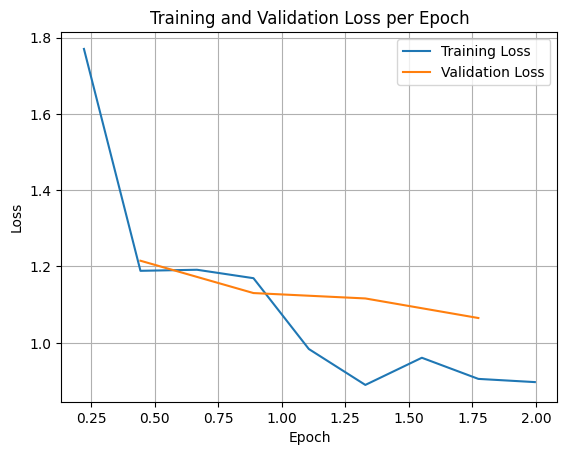

In [23]:
# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

Of course, here is an updated version of the markdown that is more streamlined and directly incorporates the code.

### Saving the Fine-Tuned Model and Tokenizer

The following code saves the fine-tuned LoRA adapter and the tokenizer to a directory. This is a crucial step to ensure that the trained components can be easily reloaded for inference or further training later.

1.  **Saving the LoRA Adapter**:
    The command `trainer.model.save_pretrained(output_dir)` saves only the trained LoRA adapter weights, not the full model. This is one of the key advantages of PEFT/LoRA, as the resulting adapter is very small (typically just a few megabytes). This file can be loaded on top of the original base model to restore its fine-tuned behavior.

2.  **Saving the Tokenizer**:
    The command `tokenizer.save_pretrained(output_dir)` saves the tokenizer's configuration and vocabulary files. It is essential to save the tokenizer that was used during training to ensure that text is processed identically during inference. This prevents potential issues caused by tokenization mismatches.

In [24]:
# Save trained LoRA adapter and the tokenizer
trainer.model.save_pretrained("qlora-Gemma3-model")
tokenizer.save_pretrained("qlora-Gemma3-model")

('qlora-Gemma3-model/tokenizer_config.json',
 'qlora-Gemma3-model/special_tokens_map.json',
 'qlora-Gemma3-model/chat_template.jinja',
 'qlora-Gemma3-model/tokenizer.model',
 'qlora-Gemma3-model/added_tokens.json',
 'qlora-Gemma3-model/tokenizer.json')

This cell uploads your fine-tuned model components to the Hugging Face Hub, making them publicly accessible and easy for you or others to reuse later.

In [25]:
if not DEMO:
  repo_name = f"lmassaron/qlora4b-Gemma3-1B-finsent"

  # Push the model to the Hub
  trainer.model.push_to_hub(repo_name)

  # Push the tokenizer to the Hub
  tokenizer.push_to_hub(repo_name)

  print(f"Model and tokenizer pushed to {repo_name}")

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          | 30.0kB /  209MB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mpoyrxm3xq/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

  ...poyrxm3xq/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer pushed to lmassaron/qlora4b-Gemma3-1B-finsent


The following code performs sentiment label prediction on the test set and evaluates the model's performance:

1. **Predict Sentiment Labels**:  
   The `predict(X_test, model, tokenizer)` function is called to predict the sentiment labels for the test dataset (`X_test`). This function generates predictions based on the fine-tuned model.

2. **Evaluate Model Performance**:  
   The `evaluate(y_true, y_pred)` function is used to assess the model's performance by comparing the true sentiment labels (`y_true`) with the predicted labels (`y_pred`). The evaluation will compute metrics like accuracy, precision, recall, and F1-score, which provide insights into how well the model is performing for each sentiment class.

With a well-fine-tuned model, we expect to achieve an overall accuracy of over 0.8, and the performance for individual sentiment labels (positive, negative, and neutral) should be high, especially for positive and negative classes. While there might still be room for improvement in predicting neutral sentiment, the results should be impressive given the relatively small dataset and the use of fine-tuning.

In [26]:
model.eval()
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

Predicting Sentiments: 100%|██████████| 900/900 [05:00<00:00,  3.00it/s]

Overall Accuracy: 0.858
Accuracy for label 0 (negative): 0.953
Accuracy for label 1 (neutral): 0.777
Accuracy for label 2 (positive): 0.843

Classification Report:
               precision    recall  f1-score   support

    positive       0.93      0.95      0.94       300
     neutral       0.83      0.78      0.80       300
    negative       0.82      0.84      0.83       300

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900


Confusion Matrix:
 [[286   8   6]
 [ 16 233  51]
 [  6  41 253]]


The model performs particularly well with the **negative class** (high recall), showing strong performance in identifying negative sentiment. The **positive class** also shows good results, with a high recall and F1-score, but the **neutral class** still lags behind, with more modest recall and F1-score.

The **confusion matrix** indicates that the model frequently predicts positive and negative sentiment correctly, with only a few neutral instances misclassified as positive or negative.

Compared to the results previously obtained by fine-tuning **Gemma 7B-IT** (see: [Fine-tune Gemma 7B-IT for sentiment analysis](https://www.kaggle.com/code/lucamassaron/fine-tune-gemma-7b-it-for-sentiment-analysis)), we have to admit that, despite being a smaller model, the **Gemma 3 1B-IT** shows impressive potential for sentiment analysis. While the **Gemma 7B-IT quantized 4-bit** model certainly excels in overall accuracy and demonstrates better performance for the **neutral sentiment** class, it’s important to remember that **Gemma 3 1B-IT** is significantly more lightweight — seven times smaller — yet still delivers remarkable results.

The **Gemma 3 1B-IT** model excels in classifying **negative sentiment**, achieving high accuracy and recall, and with additional fine-tuning, its performance on **neutral sentiment** could further improve. The **neutral sentiment** class, while not as strong as the 7B model, still shows promising potential and can be enhanced with targeted adjustments.

The **Gemma 3 1B-IT** model offers a great trade-off between performance and computational efficiency, making it an attractive option for developers and researchers with limited resources or those needing faster deployment. While **Gemma 7B-IT** may offer a more balanced performance overall, **Gemma 3 1B-IT** is a powerful and efficient alternative, showing strong potential with fine-tuning, especially in terms of **negative sentiment classification**.

this code organizes the results of a model's performance on a test set into a structured table and saves it to a CSV file for easy analysis.

In [27]:
evaluation = pd.DataFrame({'text': X_test["text"],
                           'y_true':y_true,
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)

Of course. Here is a brief explanation.

This code block **combines the small, trained LoRA adapter with the original base model to create a single, full-sized, standalone fine-tuned model.**

It performs three key actions:

1.  **`merged_model = trainer.model.merge_and_unload()`**: This is the core step. It "bakes in" the fine-tuning by mathematically merging the LoRA adapter's weights into the base model's weights. It then unloads the now-redundant adapter from memory, leaving you with a single, unified model.

2.  **`merged_model.save_pretrained(...)`**: This command saves the newly created, full-sized merged model to a directory. Unlike saving just the adapter (which is very small), this saves the entire multi-billion parameter model, making it larger but easier to deploy.

3.  **`tokenizer.save_pretrained(...)`**: This saves the tokenizer into the same directory, bundling everything needed for inference into one convenient location. Now, anyone can load this single directory to get the complete, ready-to-use fine-tuned model and its correct tokenizer.

In [28]:
# Merge LoRA and base model and save
merged_model = trainer.model.merge_and_unload()
merged_model.save_pretrained("merged4q-Gemma3-model")
tokenizer.save_pretrained("merged4q-Gemma3-model")

('merged4q-Gemma3-model/tokenizer_config.json',
 'merged4q-Gemma3-model/special_tokens_map.json',
 'merged4q-Gemma3-model/chat_template.jinja',
 'merged4q-Gemma3-model/tokenizer.model',
 'merged4q-Gemma3-model/added_tokens.json',
 'merged4q-Gemma3-model/tokenizer.json')

In [29]:
if not DEMO:
  repo_name = f"lmassaron/merged-LoRA-Gemma3-1B-finsent"

  # Push the model to the Hub
  merged_model.push_to_hub(repo_name)

  # Push the tokenizer to the Hub
  tokenizer.push_to_hub(repo_name)

  print(f"Model and tokenizer pushed to {repo_name}")

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...oopu8u0/model.safetensors:   1%|          | 15.7MB / 1.57GB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...p97negros/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...mp97negros/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


Model and tokenizer pushed to lmassaron/merged-LoRA-Gemma3-1B-finsent


this code **calculates and prints the total disk size of the two different model types you saved**: the small LoRA adapter and the large, fully merged model.

It works in two main parts:

1.  **The `get_directory_size` function:**
    This is a helper utility. It "walks" through every single file within a given directory (and all its subdirectories), gets the size of each one, and adds them all together to calculate a total size in bytes.

2.  **The Main Loop:**
    The main part of the code then iterates through your two model directories (`qlora-Gemma3-model` and `merged4q-Gemma3-model`). For each one, it:
    *   Calls the function to get its total size in bytes.
    *   Converts this byte value into gigabytes (GB).
    *   Prints the final size in a formatted, easy-to-read way.

The purpose of this is to clearly demonstrate the practical difference in file size between saving just the efficient **LoRA adapter** versus saving the entire, standalone **merged model**.

In [30]:
def get_directory_size(directory_path):
    """Calculates the total size of a directory and its subdirectories in bytes."""
    total_size = 0
    # os.walk generates the file names in a directory tree
    for dirpath, dirnames, filenames in os.walk(directory_path):
        for f in filenames:
            # os.path.join creates a full file path
            fp = os.path.join(dirpath, f)
            # os.path.getsize gets the size of the file
            # os.path.islink checks to avoid errors with symbolic links
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

bytes_to_gb = 1024 * 1024 * 1024 # or 1e9 for Gigabytes vs. Gibibytes

for directory in ["./qlora-Gemma3-model", "./merged4q-Gemma3-model"]:
    # Get size in bytes
    size_in_bytes = get_directory_size(directory)

    # Convert to GB
    size_in_gb = size_in_bytes / bytes_to_gb

    # Print the result, formatted to 2 decimal places
    print(f"Directory '{directory}': {size_in_gb:.2f} GB")

Directory './qlora-Gemma3-model': 0.23 GB
Directory './merged4q-Gemma3-model': 1.50 GB


In [31]:
def extract_last_json_block(text: str) -> str | None:
    """Extracts the last substring enclosed in curly braces {...} from a given string"""
    # Find the last closing curly brace
    last_close_brace_index = text.rfind('}')

    # If no closing brace is found, we can't find a block
    if last_close_brace_index == -1:
        return None

    # Starting from the position of the last closing brace,
    # find the last opening curly brace that comes before it.
    last_open_brace_index = text.rfind('{', 0, last_close_brace_index)

    # If no opening brace is found before the last closing brace, it's not a valid block
    if last_open_brace_index == -1:
        return None

    # Return the slice of the string between the two braces
    return text[last_open_brace_index : last_close_brace_index + 1]

In [32]:
import json

def predict_with_reasoning(X_test, model, tokenizer, device="auto", max_new_tokens=300, temperature=0.0):
    """Predict the sentiment of news headlines and extract the reasoning"""

    y_pred = []  # List to store predicted sentiment strings
    all_reasonings = [] # List to store the reasoning strings

    # Iterate through each headline in X_test
    for i in tqdm(range(len(X_test)), desc="Predicting Sentiments"):
        headline = X_test.iloc[i]["text"].split("[")[-1].split("]")[0]  # Extract headline text

        # Construct the prompt to request a JSON output
        prompt = f"""
        Analyze the sentiment of the following headline and provide your reasoning.
        The sentiment can be 'positive', 'negative', or 'neutral'.
        Return the output as a JSON object with two keys: 'sentiment' and 'reasoning'.
        In the reason briefly explain the reaasoning for the sentiment.

        Headline: "{headline}"

        JSON output:
        """

        # Tokenize and move input to the appropriate device
        input_ids = tokenizer(prompt, return_tensors="pt").to(device)

        # Generate output from the model
        params = {"do_sample": True, "temperature": temperature} if temperature > 0 else {"do_sample": False}

        outputs = model.generate(**input_ids,
                                 max_new_tokens=max_new_tokens,
                                 **params)

        # Decode the generated output into text
        result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        if "{" in result and "}" not in result:
          result = result + "\"}"

        # Extract and parse the JSON from the result
        try:
            # Extract the JSON part of the string
            json_string = extract_last_json_block(result)

            # Parse the JSON string into a Python dictionary
            parsed_json = json.loads(json_string)

            # Append the sentiment to y_pred, providing a default if the key is missing
            y_pred.append(parsed_json.get("sentiment", "none"))

            # Append the reasoning, providing a default if the key is missing
            all_reasonings.append(parsed_json.get("reasoning", "No reasoning provided."))

        except:
            error_reason = "Failed to decode JSON from the output."
            y_pred.append("none")
            all_reasonings.append(result)

    return y_pred, all_reasonings

In [33]:
y_pred, explanations = predict_with_reasoning(X_test[:10], merged_model.eval(), tokenizer, device=device, max_new_tokens=50)

Predicting Sentiments: 100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


In [34]:
for pred, reason in zip(y_pred, explanations):
    print(f"Prediction: {pred}, Reasoning: {reason}\n")

Prediction: positive, Reasoning: The headline expresses optimism about the soy-oats' potential to enter the UK market, suggesting a positive outlook.

Prediction: positive, Reasoning: The headline indicates a significant increase in sales, suggesting positive growth.

Prediction: positive, Reasoning: The headline indicates a positive agreement between M-real and Sappi, suggesting a beneficial partnership and potential future growth.

Prediction: positive, Reasoning: The headline expresses positive sentiment due to the mention of 'strong customer interest' and 'feedback', suggesting that the mentioned entities are likely to improve their products

Prediction: positive, Reasoning: The headline expresses positive sentiment towards Activision and Rapala, highlighting a fresh and colorful approach.

Prediction: positive, Reasoning: The headline indicates a positive turning point in steel prices, suggesting increased profitability and favorable market conditions.

Prediction: positive, Reaso